In [83]:
# Fix randomness and hide warnings
seed = 42

from pathlib import Path
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

# Import tensorflow
import tensorflow as tf
import keras_cv
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.random.set_seed(seed)
print(f"TensorFlow version {tf.__version__}")
tfk.utils.set_random_seed(seed)


# Import other libraries
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.rc('font', size=14)
%matplotlib inline
import seaborn as sns
sns.set(font_scale=1.4)
sns.set_style('white')
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, recall_score, precision_score, confusion_matrix, accuracy_score, f1_score
from PIL import Image
from collections import Counter
import cv2

import keras
from keras import layers

# TF imports related to tf.data preprocessing
from tensorflow import clip_by_value
from tensorflow import data as tf_data
from tensorflow import image as tf_image
from tensorflow import random as tf_random
from tensorflow.keras import mixed_precision as tfk_mixed_precision

default_policy = tfk_mixed_precision.global_policy()

cwd = Path(os.getcwd())
input_dir = cwd.parent / 'input'

print('input directory: ', input_dir)
print('current working directory: ', cwd)

TensorFlow version 2.16.1
input directory:  /kaggle/input
current working directory:  /kaggle/working


# Load dataset and inspect

Images shape:  (18640, 96, 96, 3)
labels shape:  (18640, 1)
Images dtype:  uint8
labels dtype:  uint8
max min images:  255 0
max min labels:  7 0


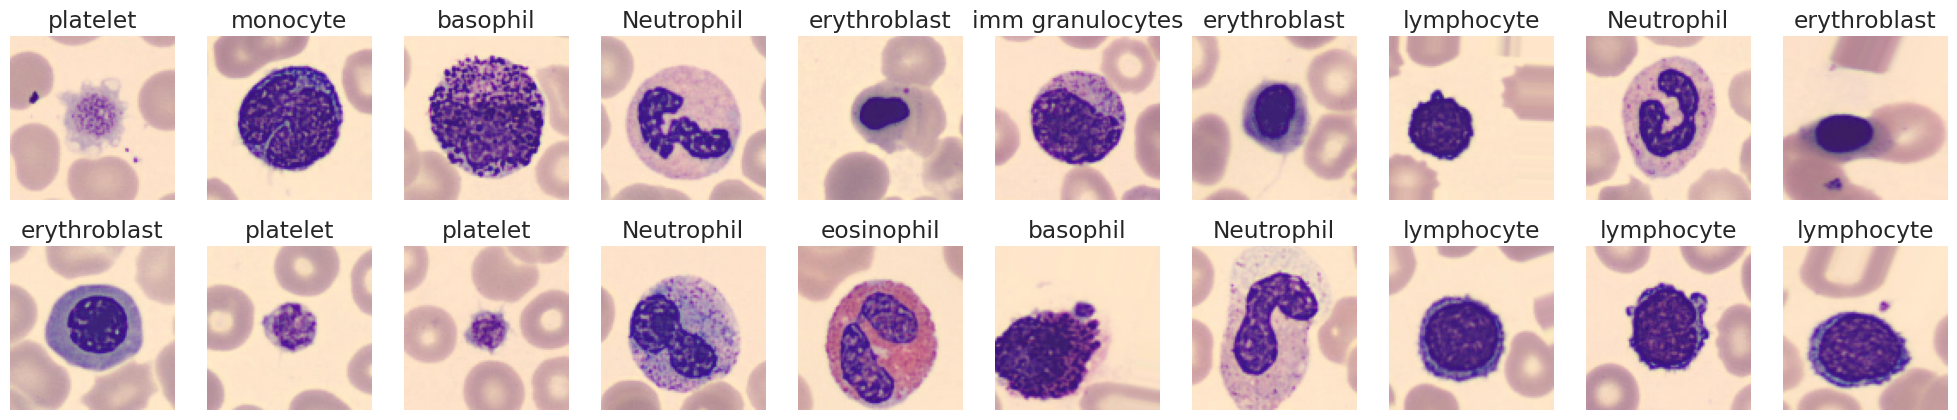

In [84]:
dataset_dir = input_dir / 'ann-h1-round1-dataset'
dataset_name = 'training_set_cleaned_balanced.npz'

data = np.load(dataset_dir / dataset_name)
X = data['images']
y = data['labels']
print('Images shape: ', X.shape)
print('labels shape: ', y.shape)
print('Images dtype: ', X.dtype)
print('labels dtype: ', y.dtype)
print('max min images: ', np.max(X), np.min(X))
print('max min labels: ', np.max(y), np.min(y))

labels = {0:'basophil',
          1: 'eosinophil',
          2: 'erythroblast',
          3: 'imm granulocytes',
          4: 'lymphocyte',
          5: 'monocyte',
          6: 'Neutrophil',
          7: 'platelet'}

fig, ax = plt.subplots(2,10, figsize=(25,5))
ax = ax.flatten()


for i in range(len(ax)):
  idx = random.randint(0,X.shape[0]-1)
  ax[i].imshow(X[idx,:,:,:])
  ax[i].axis('off')
  ax[i].set_title(f'{labels[y[idx][0]]}')
plt.show()

Transform y to categorical

In [85]:
y = tfk.utils.to_categorical(y)
print('labels categoriche: ',y.shape)

labels categoriche:  (18640, 8)


## Perform train test split

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,random_state=seed, stratify=y)

print('X train: ', X_train.shape)
print('y train: ',y_train.shape)

print('X test: ', X_test.shape)
print('y test: ',y_test.shape)

print('y_train type: ', y_train.dtype)
print('x train type: ', X_train.dtype)

X train:  (16776, 96, 96, 3)
y train:  (16776, 8)
X test:  (1864, 96, 96, 3)
y test:  (1864, 8)
y_train type:  float64
x train type:  uint8


## Convert to tensorflow dataset object

In [87]:
AUTO = tf_data.AUTOTUNE
BATCH_SIZE = 32
IMG_SIZE = 96

Occhio che qua faccio un cast a float32

In [88]:
def to_dict(image, label):
    return {"images": image, "labels": label}


def load_dataset(split):
    if split == 'train':
        ds = (
            tf_data.Dataset.from_tensor_slices((X_train, y_train))
            .shuffle(300 * BATCH_SIZE, seed=seed)
            .map(to_dict, num_parallel_calls=AUTO)
            .batch(BATCH_SIZE)
        )
        return ds
    elif split == 'test':
        ds = (
            tf_data.Dataset.from_tensor_slices((X_test, y_test))
            .map(to_dict, num_parallel_calls=AUTO)
            .batch(BATCH_SIZE)
        )
        return ds


train_ds = load_dataset('train')
test_ds = load_dataset('test')



This is just visualization

In [89]:
for sample in train_ds.take(1):
    print(sample.keys())  # Dovrebbe stampare: dict_keys(['images', 'labels'])
    print(sample["images"].shape)  # Stampa la shape delle immagini
    print(sample["labels"].shape)  # Stampa la shape delle label

for sample in train_ds.take(1):
    print(f"Min pixel value: {tf.reduce_min(sample['images'])}\nMax pixel value: {tf.reduce_max(sample['images'])}")
print(train_ds.element_spec)
print(test_ds.element_spec)

dict_keys(['images', 'labels'])
(32, 96, 96, 3)
(32, 8)
Min pixel value: 4
Max pixel value: 255
{'images': TensorSpec(shape=(None, 96, 96, 3), dtype=tf.uint8, name=None), 'labels': TensorSpec(shape=(None, 8), dtype=tf.float64, name=None)}
{'images': TensorSpec(shape=(None, 96, 96, 3), dtype=tf.uint8, name=None), 'labels': TensorSpec(shape=(None, 8), dtype=tf.float64, name=None)}


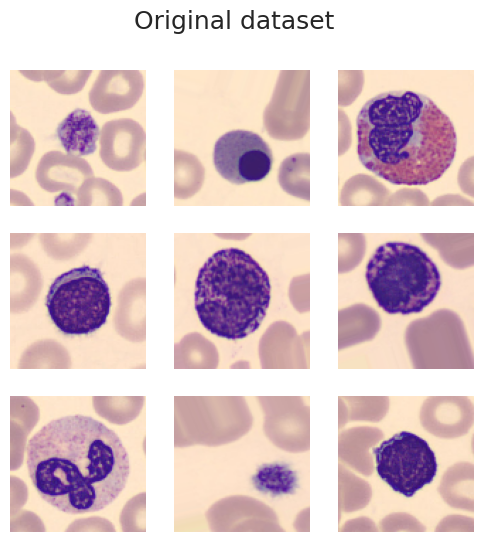

In [90]:
def visualize_dataset(dataset, title):
    plt.figure(figsize=(6, 6)).suptitle(title, fontsize=18)
    for i, samples in enumerate(iter(dataset.take(9))):
        images = samples["images"]
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[0].numpy())
        plt.axis("off")
    plt.show()



visualize_dataset(train_ds, 'Original dataset')

# Random augmentation layer

In [91]:
rand_augment = keras_cv.layers.RandAugment(
    value_range=(0,255),
    augmentations_per_image=1,
    magnitude=0.3,
    magnitude_stddev=0.2,
    rate=0.3,
)


def apply_rand_augment(inputs):
    inputs["images"] = rand_augment(inputs["images"])
    return inputs

layers = []

In [92]:
layers_rnd_aug = keras_cv.layers.RandAugment.get_standard_policy(
    value_range=(0,255),
    magnitude=0.3,
    magnitude_stddev=0.2)
layers.append(layers_rnd_aug)


print('layers di augmentation')
print(layers)

layers di augmentation
[[<AutoContrast name=auto_contrast_11, built=False>, <Equalization name=equalization_9, built=False>, <Solarization name=solarization_9, built=False>, <RandomColorDegeneration name=random_color_degeneration_11, built=False>, <RandomContrast name=random_contrast_9, built=False>, <RandomBrightness name=random_brightness_9, built=False>, <RandomShear name=random_shear_18, built=False>, <RandomShear name=random_shear_19, built=False>, <RandomTranslation name=random_translation_21, built=False>, <RandomTranslation name=random_translation_22, built=False>]]


# Channel shift layer

In [93]:
ch_shift = keras_cv.layers.RandomChannelShift(
    value_range=(0,255), factor=0.5, channels=3, seed=seed)


def apply_ch_shift(inputs):
    inputs['images'] = ch_shift(inputs['images'])
    return inputs

layers.append(ch_shift)

# Color degeneration layer

In [94]:
color_deg = keras_cv.layers.RandomColorDegeneration(factor=0.5, seed=seed)

def apply_col_deg(inputs):
    inputs['images'] = color_deg(inputs['images'])
    return inputs


# Catmix e mixup layer

In [95]:
cut_mix = keras_cv.layers.CutMix(seed=seed, alpha=1.0) # default alpha
mix_up = keras_cv.layers.MixUp(seed=seed, alpha=0.4) # non default alpha

# randomly executes cut mix and mix up augmentation with a given probability
augmentation_probability = 0.5


def apply_cut_mix_and_mix_up(samples):
    samples['images'] = tf.cast(samples['images'], tf.float32)
    samples['labels'] = tf.cast(samples['labels'], tf.float32)


    tf.debugging.assert_rank(samples["images"], 4, 
                             "Le immagini devono avere 4 dimensioni (batch, height, width, channels)")
    tf.debugging.assert_rank(samples["labels"], 2, 
                             "Le labels devono essere batch e one-hot encoded")

    rand_value = tf.random.uniform([], 0, 1)
    if rand_value < augmentation_probability:
        samples = cut_mix(samples)

    rand_value = tf.random.uniform([], 0, 1)
    if rand_value < augmentation_probability:
        samples = mix_up(samples)

    return samples


# Grid mask

In [96]:
gm = keras_cv.layers.GridMask(
    ratio_factor=(0.0, 0.5),
    rotation_factor=0.15,
    fill_mode="constant",
    fill_value=0.0,
    seed=seed,
)


def apply_grid_mask(dataset):
    dataset['images'] = gm(dataset['images'])
    return dataset

layers.append(gm)

# Auto contrast

In [97]:
ac = keras_cv.layers.AutoContrast(value_range=(0,255), seed=seed)

def apply_auto_contrast(dataset):
    dataset['images'] = ac(dataset['images'])
    return dataset


# Channel shuffle 

In [98]:
cs = keras_cv.layers.ChannelShuffle(seed=seed)

def apply_ch_shuffle(dataset):
    dataset['images'] = cs(dataset['images'])
    return dataset

layers.append(cs)

# Apply augmentation pipeline
HERE with the .map method you can call all augmentation layers that you want and that you have defined above

In [99]:


# NOT USED for now
pipeline = keras_cv.layers.RandomAugmentationPipeline(
    layers=layers, 
    augmentations_per_image=3,
    rate=0.6,
    seed=seed
)

augmentation = tf.keras.Sequential([
    tfkl.RandomFlip("horizontal_and_vertical"),
    tfkl.RandomTranslation(0.3,0.3),
    tfkl.RandomRotation(0.3),
    tfkl.RandomContrast(0.3),
    tfkl.RandomBrightness(0.3, value_range=(0.0, 1.0), seed=seed),
    keras_cv.layers.RandomChannelShift(value_range=(0, 255), factor=0.5),
    keras_cv.layers.ChannelShuffle(groups=3, seed=None),
    ac = keras_cv.layers.AutoContrast(value_range=(0,255), seed=seed)
    
], name='Augmentation')

def apply_pipeline(images,labels):
    images = pipeline(images)
    return images,labels

def appl_pip(samples):
    samples['images'] = appl_pip(samples['images'])
    return samples


train_ds_prep = (train_ds
                 .map(apply_cut_mix_and_mix_up, num_parallel_calls=AUTO)
                )

test_ds_prep = (test_ds
               .map(apply_cut_mix_and_mix_up, num_parallel_calls=AUTO)
               )

# Prepare for training

In [100]:
def preprocess_for_model(inputs):
    images, labels = inputs["images"], inputs["labels"]
    images = tf.cast(images, tf.uint8)
    return images, labels

# Prepare TRAIN dataset for training
train_dataset_ready = (train_ds_prep
                        .map(preprocess_for_model, num_parallel_calls=AUTO))

# Prepare TEST dataset for training
test_dataset_ready = (test_ds_prep
                      .map(preprocess_for_model, num_parallel_calls=AUTO))
# Implement PREFETCH
#train_dataset_ready = train_dataset.prefetch(AUTO)
#test_dataset_ready = test_dataset.prefetch(AUTO)
test_ds_1 = (test_ds
          .map(preprocess_for_model, num_parallel_calls=AUTO))

#train_ds_final = train_dataset_ready.map(apply_pipeline, num_parallel_calls=AUTO)


print(train_dataset_ready.element_spec)

(TensorSpec(shape=(None, 96, 96, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 8), dtype=tf.float32, name=None))


tf.Tensor(
[0.         0.         0.08909261 0.         0.         0.
 0.         0.9109074 ], shape=(8,), dtype=float32)
tf.Tensor(
[0.         0.         0.89673096 0.         0.         0.10326904
 0.         0.        ], shape=(8,), dtype=float32)
tf.Tensor(
[0.         0.         0.         0.28951815 0.         0.
 0.         0.7104819 ], shape=(8,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 1. 0.], shape=(8,), dtype=float32)
tf.Tensor(
[0.6605573  0.         0.         0.33944267 0.         0.
 0.         0.        ], shape=(8,), dtype=float32)
tf.Tensor(
[0.         0.         0.01447421 0.         0.         0.
 0.9855258  0.        ], shape=(8,), dtype=float32)
tf.Tensor(
[0.         0.58072823 0.         0.41927177 0.         0.
 0.         0.        ], shape=(8,), dtype=float32)
tf.Tensor(
[0.         0.         0.45598686 0.         0.         0.
 0.54401314 0.        ], shape=(8,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0. 0. 0. 0.], shape=(8,), dtype=float32)


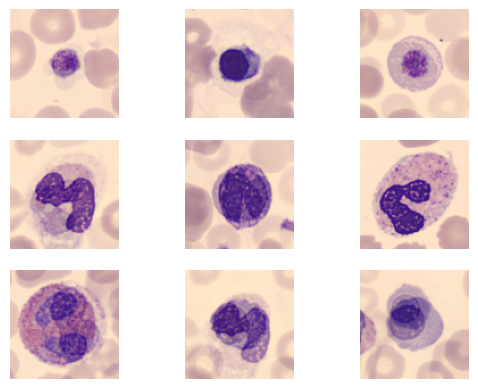

In [101]:
#visualize_dataset(train_ds_prep, title='augmented dataset')
for image, label in train_dataset_ready.take(1):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(image[i])
        plt.axis('off')
        print(label[i])

In [102]:
for images, labels in train_dataset_ready.take(1):
    print(f"Min pixel value: {tf.reduce_min(images)}\nMax pixel value: {tf.reduce_max(images)}")
    print(images.shape)
    print(images.dtype)
    print(labels.shape)
    #print("Pixel range:", tf.reduce_min(image), tf.reduce_max(image))


Min pixel value: 7
Max pixel value: 255
(32, 96, 96, 3)
<dtype: 'uint8'>
(32, 8)


# Set up the model and train

In [103]:
base_model = tfk.applications.EfficientNetB3(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE,IMG_SIZE,3),
)

base_model.trainable = False
base_model.summary()

Model: "efficientnetb3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 96, 96, 3) │          0 │ input_layer_3[0]… │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 96, 96, 3) │          7 │ rescaling_2[0][0] │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 96, 96, 3) │          0 │ normalization_1[… │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 97, 97, 3) │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 48, 48,    │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 48, 48,    │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 48, 48,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 48, 48,    │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 48, 48,    │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 48, 48,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 48, 48,    │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 48, 48,    │        960 │ block1a_se_excit

 Total params: 10,783,535 (41.14 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 10,783,535 (41.14 MB)

In [104]:
# for i, layer in enumerate(base_model.layers):
#   print(i, layer.name, type(layer).__name__, layer.trainable)

In [105]:
def build_model(input_shape, 
                output_shape, 
                augmentation=None, 
                learning_rate=1e-3, 
                plot_model=False, 
                name='model', 
                glob_avg_needed=True):
    
    input = tfkl.Input(shape=input_shape, name='Input_layer')
    # x = tfk.applications.efficientnet.preprocess_input(input)
    
    if augmentation:
        x = augmentation(input)
    else:
        x = input
    
    
    # connect to the base model
    x = base_model(x)
 
    if glob_avg_needed:
        # Make a global avarage if not included in the pretrained architecture
        x = tfkl.GlobalAveragePooling2D()(x)
    
    x = tfkl.Dropout(0.2, name='dropout2')(x)

    # 1st dense layer of the classifier
    x = tfkl.Dense(units=1024, activation='relu', name='dense1')(x)
    x = tfkl.Dropout(0.2, name='drop_dense_1')(x)

    # 2nd dense layer of the classifier
    x = tfkl.Dense(units=512, activation='relu', name='dense2')(x)
    
    # 3rd dense layer of the classifier
    x = tfkl.Dense(units=256, activation='relu', name='dense3')(x)
    x = tfkl.Dropout(0.2, name='drop_dense_2')(x)
    
    # output layer
    output = tfkl.Dense(units=output_shape, activation='softmax', name='output')(x)
    
    # Create a Model connecting input and output
    model = tfk.Model(inputs=input, outputs=output, name=name)
    
    # Compile the model with Categorical Cross-Entropy loss and Adam optimizer
    model.compile(loss=tfk.losses.CategoricalCrossentropy(),
                  optimizer=tfk.optimizers.AdamW(learning_rate),
                  metrics=['accuracy'])
        
    if plot_model:
        model.summary()
        tfk.utils.plot_model(model, show_shapes=True, dpi=70)

    return model

In [107]:
#initial_model = training_model()
#initial_model.save_weights("initial_weights.weights.h5")
lr = 1e-3

model = build_model(input_shape=(IMG_SIZE,IMG_SIZE,3), 
                    output_shape=8, 
                    augmentation=augmentation, # QUI HO MODIFICATO (era augmentation) 
                    name='efficientB3_catmix_mixup_rnd_2',
                    glob_avg_needed=True,
                   learning_rate=lr)
model.summary()

Model: "efficientB3_catmix_mixup_rnd_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_layer (InputLayer)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Augmentation (Sequential)       │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb3 (Functional)     │ (None, 3, 3, 1536)     │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 1024)           │     1,573,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop_dense_1 (Dropout)          │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense3 (Dense)                  │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop_dense_2 (Dropout)          │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,015,607 (49.65 MB)

 Trainable params: 2,232,072 (8.51 MB)

 Non-trainable params: 10,783,535 (41.14 MB)

In [108]:
patience = 20
es = tfk.callbacks.EarlyStopping(monitor='val_accuracy',
                                 mode='max',
                                 patience=patience,
                                 restore_best_weights=True,
                                 start_from_epoch=5)

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir='./logs',
    histogram_freq=1
)

rlrop = tfk.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=100,
    min_delta=0.0001
)

callbacks = [es,tensorboard_callback,rlrop]

In [ ]:
EPOCHS = 500
# this is to speed up training (supposedly)
tfk.mixed_precision.set_global_policy('mixed_float16')


history = model.fit(train_dataset_ready, 
          validation_data=test_dataset_ready,
          epochs=EPOCHS, 
          callbacks=callbacks).history

tfk_mixed_precision.set_global_policy(default_policy)

Epoch 1/500


2024-11-16 13:31:56.979345: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/efficientB3_catmix_mixup_rnd_2_1/efficientnetb3_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


525/525 ━━━━━━━━━━━━━━━━━━━━ 60s 68ms/step - accuracy: 0.3932 - loss: 1.7091 - val_accuracy: 0.5960 - val_loss: 1.3433 - learning_rate: 0.0010
Epoch 2/500
524/525 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5149 - loss: 1.4721

In [28]:
final_val_accuracy = round(max(history['val_accuracy']) * 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file, including final accuracy in the filename
model_filename = f'{model.name}_' + str(final_val_accuracy) + '.keras'
model.save(model_filename)


Final validation accuracy: 65.77%


In [34]:
# evaluate on the original dataset
model = tfk.models.load_model('/kaggle/working/efficientB3_catmix_mixup_rnd_2_65.77.keras')
test_loss, test_accuracy = model.evaluate(test_ds_1)
print("Test accuracy: {:.2f}%".format(test_accuracy * 100))


59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.6123 - loss: 1.1231
Test accuracy: 61.11%


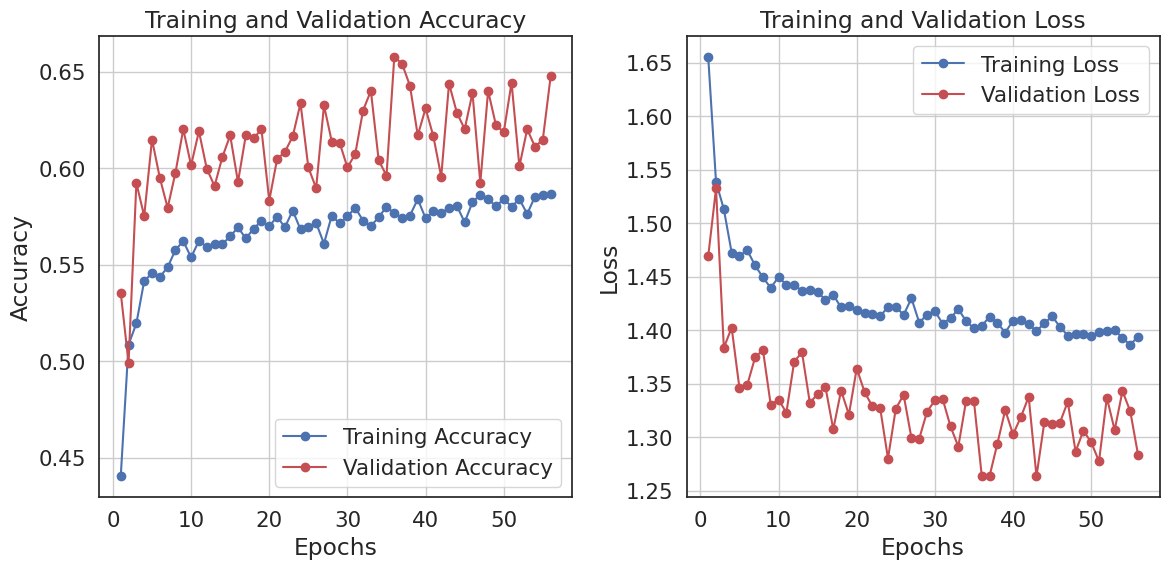

In [35]:
def plot_metrics_from_dict(metrics_dict):
    """
    Funzione per plottare l'andamento di training e validation accuracy, e training e validation loss
    a partire da un dizionario contenente le metriche.

    Parametri:
        metrics_dict: Dizionario con chiavi 'accuracy', 'val_accuracy', 'loss' e 'val_loss'.
    """

    # Estrai le metriche dal dizionario
    acc = metrics_dict.get('accuracy', [])
    val_acc = metrics_dict.get('val_accuracy', [])
    loss = metrics_dict.get('loss', [])
    val_loss = metrics_dict.get('val_loss', [])

    if not acc or not loss:
        print("Errore: Il dizionario fornito non contiene le chiavi 'accuracy' o 'loss'.")
        return

    # Numero di epoche
    epochs = range(1, len(acc) + 1)

    # Plot dell'accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    # Plot della loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    # Mostra i plot
    plt.tight_layout()
    plt.show()


plot_metrics_from_dict(history)
del model

# Fine tuning 

## load model

In [ ]:
model = tfk.models.load_model(f'{model.name}_' + str(final_val_accuracy) + '.keras')

## sets weights to trainable

In [ ]:
efficientB3 = model.get_layer('efficientnetb3')


n_conv = len([x for x in efficientB3.layers if isinstance(x,tfkl.Conv2D)])
n_layers = len(efficientB3.layers)
print('N conv layer: ', n_conv)
print('N layers: ', n_layers)

for layer in efficientB3.layers[n_layers//2:]:
    if isinstance(layer, (tfkl.Conv2D,
                          tfkl.DepthwiseConv2D)):
        layer.trainable=True

tfk.utils.plot_model(efficientB3, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)


## compile the model 

In [ ]:
learning_rate = 1e-4
model.compile(loss=tfk.losses.CategoricalCrossentropy(),
                   optimizer=tfk.optimizers.AdamW(learning_rate),
                   metrics=['accuracy'])

In [ ]:
EPOCHS = 500


history = model.fit(train_dataset_ready, 
          validation_data=test_dataset_ready,
          epochs=EPOCHS, 
          callbacks=callbacks).history

# Calculate and print the best validation accuracy achieved
final_val_accuracy = round(max(history['val_accuracy']) * 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file, including final accuracy in the filename
model_filename = f'{model.name}_' + 'ft' +str(final_val_accuracy) + '.keras'
base_model.save(model_filename)

# Free memory by deleting the model instance
del model

# Fine tuning round 2

In [ ]:
model = tfk.models.load_model(f'{model.name}_' + 'ft' +str(final_val_accuracy) + '.keras')

## set all convs to trainable

In [53]:
efficientB3 = model.get_layer('efficientnetb3')


n_conv = len([x for x in efficientB3.layers if isinstance(x,tfkl.Conv2D])
n_layers = len(efficientB3.layers)
print('N conv layer: ', n_conv)
print('N layers: ', n_layers)

for layer in efficientB3.layers:
    if isinstance(layer, (tfkl.Conv2D,
                         tfkl.DepthwiseConv2D)):
        layer.trainable=True

tfk.utils.plot_model(efficientB3, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)


NameError: name 'model' is not defined

In [ ]:
learning_rate = 1e-5
model.compile(loss=tfk.losses.CategoricalCrossentropy(),
                   optimizer=tfk.optimizers.AdamW(learning_rate),
                   metrics=['accuracy'])

In [ ]:
EPOCHS = 500


history = model.fit(train_dataset_ready, 
          validation_data=test_dataset_ready,
          epochs=EPOCHS, 
          callbacks=callbacks).history

In [ ]:
# Save the trained model to a file, including final accuracy in the filename
model_filename = f'{model.name}_' + 'ft2' + str(final_val_accuracy) + '.keras'
model.save(model_filename)
del model

#